# This notebook connects to V-REP to read the joint angles from Baxter

# SQUARE

## Baxter arm specifications:
http://sdk.rethinkrobotics.com/wiki/Hardware_Specifications#Baxter_Arm_Specifications

In [3]:
import vrep
import numpy
import time
import sys
import subprocess
import save_load_file as slf

%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
#
# Controls if the results are saved to a file
#

save2file = False

In [ ]:
# Location of the V-REP simulator main file:
vrep_location = "/Applications/V-REP_PRO_EDU_V3_2_2_Mac/vrep.app/Contents/MacOS/vrep"

In [7]:
# %load movement_generation_training.py

# Generates the movements according to:
# Flash, Tamar and Neville Hogan. 1985. The Coordination of Arm Movements: An Experimentally Confirmed 
# Mathematical Model. The Journal of Neuroscience 5 (7): 1688-1703
def movement_generation_training(xstart,xdest,MT,t):
    '''
    xstart,ystart: initial position of the trajectory
    MT: total time spent doing the trajectory
    t: current time
    
    returns a matrix: [[x0,y0],[x1,y1],...]
    '''
    x_t=xstart+(xstart-xdest)*(15*(t/MT)**4-6*(t/MT)**5-10*(t/MT)**3)
    return numpy.array(x_t)

In [8]:
sim_set = "square" # basically is the name of the folder where the data is read/saved
base_dir = "BaxterArm_VREP_simulation_data"

In [9]:
MT=0.5 # The SQUARE is made of four straight lines (0.5s x 4 = 2s)
time_step=2E-3
t_mov=numpy.arange(0, MT, time_step) # t starts in 0s and steps time_step(s) until reaches MT(s)

In [10]:
# Square
trajectories = [[[-0.5,-0.5],[0.5,-0.5]],\
                [[0.5,-0.5],[0.5,0.5]],\
                [[0.5,0.5],[-0.5,0.5]],\
                [[-0.5,0.5],[-0.5,-0.5]]]

orig_trajectories = numpy.array(trajectories)

trajectories = numpy.array(trajectories)

In [11]:
# Creates an empty matrix to store the points
XY_movement = numpy.zeros((0,2))

for tji in range(4):

    xstart=trajectories[tji][0][0]
    ystart=trajectories[tji][0][1]
    xdest=trajectories[tji][1][0]
    ydest=trajectories[tji][1][1]

    x_movement = movement_generation_training(xstart,xdest,MT,t_mov)
    y_movement = movement_generation_training(ystart,ydest,MT,t_mov)
    
    XY_movement_temp = numpy.zeros((len(t_mov),2))

    XY_movement_temp[:,0]=x_movement
    XY_movement_temp[:,1]=y_movement

    # Concatenates all the lines to make a square
    XY_movement=numpy.concatenate((XY_movement,numpy.round(XY_movement_temp/6.0,4)))

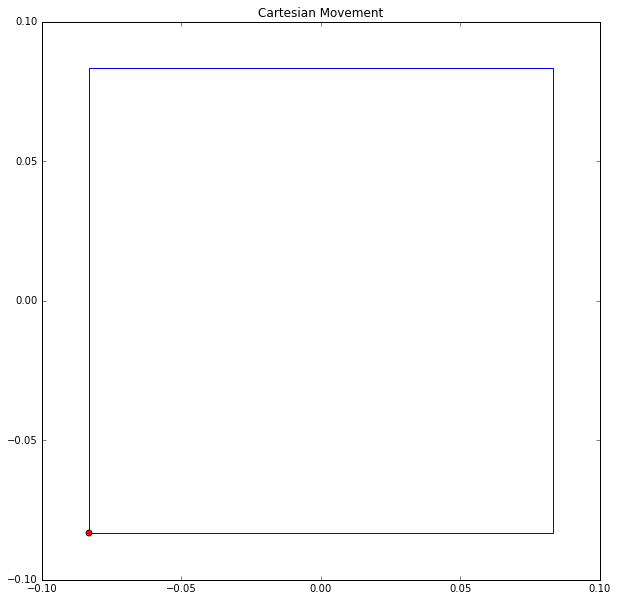

In [12]:
tji_orig = 0
plt.figure(figsize =(10,10))
plt.plot(XY_movement[:,0],XY_movement[:,1])
plt.plot([XY_movement[0,0]],[XY_movement[0,1]],'go')
plt.plot([XY_movement[-1,0]],[XY_movement[-1,1]],'ro')
# plt.xlim(-1,1)
# plt.ylim(-1,1)
plt.title("Cartesian Movement")
plt.show()

In [13]:
#
# Saves the original values to a file
# 

if save2file:
    slf.save_to_file(XY_movement,base_dir+"/"+sim_set+"/"+sim_set+".pickle")

In [ ]:
# %load vrep_training.py

import os

p = None

# To automate the process is necessary to avoid the firewall message by deactivating it!!!!


p = subprocess.Popen([vrep_location, '-h', '-s', '-q', \
                      os.getcwd()+'/VREP_scenes/Baxter_IK_felt_pen_pick-and-place_learning_IJCNN2016.ttt'])  

time.sleep(1.0)

# Object names (used inside the simulation)
# They are used to retrieve the object handles
s0_name = 'Baxter_leftArm_joint1'
s1_name = 'Baxter_leftArm_joint2'
e1_name = 'Baxter_leftArm_joint4'
w1_name = 'Baxter_leftArm_joint6'
XY_pos = 'IK_XY_MASTER' # Controls the cartesian X,Y values (pen)
Z_pos = 'IK_Z_MASTER' # Controls the cartesian Z value (pen)

# simxPauseCommunication(clientID,1);
# simxSetJointPosition(clientID,joint1Handle,joint1Value,simx_opmode_oneshot);
# simxSetJointPosition(clientID,joint2Handle,joint2Value,simx_opmode_oneshot);
# simxSetJointPosition(clientID,joint3Handle,joint3Value,simx_opmode_oneshot);
# simxPauseCommunication(clientID,0);
# Above's 3 joints will be received and set on the V-REP side at the same time

print 'Program started'
vrep.simxFinish(-1) # just in case, close all opened connections

# Connects to the simulator
clientID=vrep.simxStart('127.0.0.1',19999,True,True,5000,5)

if clientID!=-1:
    print 'Connected to remote API server'
    res,objs=vrep.simxGetObjects(clientID,vrep.sim_handle_all,vrep.simx_opmode_oneshot_wait) # gets ALL object handles
    if res==vrep.simx_return_ok:
        print 'Number of objects in the scene: ',len(objs)
        res0,XY=vrep.simxGetObjectHandle(clientID,XY_pos,vrep.simx_opmode_oneshot_wait) # gets specifically the handle for the IK_XY_MASTER
        res1,Z=vrep.simxGetObjectHandle(clientID,Z_pos,vrep.simx_opmode_oneshot_wait) # gets specifically the handle for the IK_Z_MASTER
        
        res2,s0=vrep.simxGetObjectHandle(clientID,s0_name,vrep.simx_opmode_oneshot_wait) # gets specifically the handle for the s0 joint
        res3,s1=vrep.simxGetObjectHandle(clientID,s1_name,vrep.simx_opmode_oneshot_wait) # gets specifically the handle for the s1 joint
        res4,e1=vrep.simxGetObjectHandle(clientID,e1_name,vrep.simx_opmode_oneshot_wait) # gets specifically the handle for the e1 joint
        res5,w1=vrep.simxGetObjectHandle(clientID,w1_name,vrep.simx_opmode_oneshot_wait) # gets specifically the handle for the w1 joint

        if (res1*res2*res3*res4*res5)==vrep.simx_return_ok:
            print "Ok, I'm in!"

            joint_list = [s0,s1,e1,w1]
            joint_positions = []

            #
            # These are the equivalent to X,Y,Z = 0,0,0 in my system:
            #
            
            # Reads the current XY_Master position [X,Y]
            print "Reads the current XY_Master position [X,Y]"
            res,posXY=vrep.simxGetObjectPosition(clientID,XY,vrep.sim_handle_parent,vrep.simx_opmode_oneshot_wait)
            time.sleep(0.5)
            
            # Reads the current Z_Master position [Z]
            print "Reads the current Z_Master position [Z]"
            res,posZ=vrep.simxGetObjectPosition(clientID,Z,vrep.sim_handle_parent,vrep.simx_opmode_oneshot_wait)            
            time.sleep(0.5)
            
            print "Initial XY Master Position", posXY
            print "Initial Z Master Position", posZ


            # Lifts the pen to position it in the trajectory's starting point
            # This is acomplished by increasing the Z value (posZ[2])
            print "Lifts the pen to position it in the trajectory's starting point"
            # I need a smooth movements, otherwise the pen touches the table by mistake.
            for k in range(2):
                res = vrep.simxSetObjectPosition(clientID,Z,vrep.sim_handle_parent,[posZ[0], posZ[1], posZ[2]+0.001*(k+1)],vrep.simx_opmode_oneshot_wait)
                time.sleep(0.5)
                        
            # Moves to the first position
            # This movement is relative to the current XY position!!!
            print "Moves to the first position"
            res = vrep.simxSetObjectPosition(clientID,XY,vrep.sim_handle_parent,[posXY[0]+XY_movement[0,0], posXY[1]+XY_movement[0,1], posXY[2]],vrep.simx_opmode_oneshot_wait)
            time.sleep(0.5)
            
            
            # Puts down the pen
            print "Puts down the pen"
            # I need smooth movements, otherwise the pen touches the table by mistake.
            # Reads the current Z_Master position [Z]
            res,posZcurrent=vrep.simxGetObjectPosition(clientID,Z,vrep.sim_handle_parent,vrep.simx_opmode_oneshot_wait)            
            time.sleep(0.5)
            for k in range(2):
                res = vrep.simxSetObjectPosition(clientID,Z,vrep.sim_handle_parent,[posZcurrent[0], posZcurrent[1], posZcurrent[2]-0.001*(k+1)],vrep.simx_opmode_oneshot_wait)
                time.sleep(0.5)            
            
            if res!=0:
                vrep.simxFinish(clientID)
                print 'Remote API function call returned with error code (start-up): ',res
          
            # Reads the current XY_Master position [X,Y]
            print "Reads the current XY_Master position [X,Y]"
            res,posXYcurrent=vrep.simxGetObjectPosition(clientID,XY,vrep.sim_handle_parent,vrep.simx_opmode_oneshot_wait)
            time.sleep(0.5)
            
            # Reads the current Z_Master position [Z]
            print "Reads the current Z_Master position [Z]"
            res,posZcurrent=vrep.simxGetObjectPosition(clientID,Z,vrep.sim_handle_parent,vrep.simx_opmode_oneshot_wait)            
            time.sleep(0.5)            

            print "XY Master Position:", posXYcurrent
            print "Z Master Position:", posZcurrent
            
            
            i = 0
            for hi in XY_movement:
                # Reads and saves the current joint positions
                temp = []
                for ji in joint_list:
                    res,joint_pos=vrep.simxGetJointPosition(clientID,ji,vrep.simx_opmode_oneshot_wait)
                    temp.append(joint_pos)
                    time.sleep(0.0025)
                joint_positions.append(temp)
                
                if i==0:
                    if save2file:
                        numpy.save(base_dir+"/"+sim_set+"/starting_joint_pos.npy",numpy.array(temp))                

                cmd_pos = numpy.array(posXY)+numpy.concatenate([hi,[0]]) # Sums X and Y in the pos and [hi[0],hi[1],0] arrays

                i+=1
                # Sets the new position
                res = vrep.simxSetObjectPosition(clientID,XY,vrep.sim_handle_parent,cmd_pos,vrep.simx_opmode_oneshot_wait)
                time.sleep(0.0025) # 0.05 here was generating too many time-out errors!                
                
                if res!=0:
                    vrep.simxFinish(clientID)
                    print 'Remote API function call returned with error code (main loop): ',res
                    break
            

            # Lifts the pen to position it in the trajectory's starting point
            # I need a smooth movements, otherwise the pen touches the table by mistake.
            # Reads the current Z_Master position [Z]
            res,posZcurrent=vrep.simxGetObjectPosition(clientID,Z,vrep.sim_handle_parent,vrep.simx_opmode_oneshot_wait)            
            time.sleep(0.5)            
        
            for k in range(2):
                res = vrep.simxSetObjectPosition(clientID,Z,vrep.sim_handle_parent,[posZcurrent[0], posZcurrent[1], posZcurrent[2]+0.001*(k+1)],vrep.simx_opmode_oneshot_wait)
                time.sleep(0.5)            

            
            # Moves it back to the first position
            res = vrep.simxSetObjectPosition(clientID,XY,vrep.sim_handle_parent,posXY,vrep.simx_opmode_oneshot_wait)
            time.sleep(0.5)
            
            # Puts down the pen
            # I need a smooth movements, otherwise the pen touches the table by mistake.
            # Reads the current Z_Master position [Z]
            res,posZcurrent=vrep.simxGetObjectPosition(clientID,Z,vrep.sim_handle_parent,vrep.simx_opmode_oneshot_wait)            
            time.sleep(0.5)
            for k in range(2):
                res = vrep.simxSetObjectPosition(clientID,Z,vrep.sim_handle_parent,[posZcurrent[0], posZcurrent[1], posZcurrent[2]-0.001*(k+1)],vrep.simx_opmode_oneshot_wait)
                time.sleep(0.5)      
                
            if res!=0:
                vrep.simxFinish(clientID)
                print 'Remote API function call returned with error code (last position): ',res
                
        else:
            print 'Remote API function call returned with error code (object handles): ',res
    else:
        print 'Remote API function call returned with error code (first connection): ',res
#     returncode=vrep.simxStopSimulation(clientID,vrep.simx_opmode_oneshot_wait)
    vrep.simxFinish(clientID)
else:
    print 'Failed connecting to remote API server'
print 'Program ended'

if p:
    # Terminates the process, in the case the connection above failed.
    p.terminate()

In [16]:
joint_positions = numpy.array(joint_positions)

In [17]:
joint_positions.shape

(1000, 4)

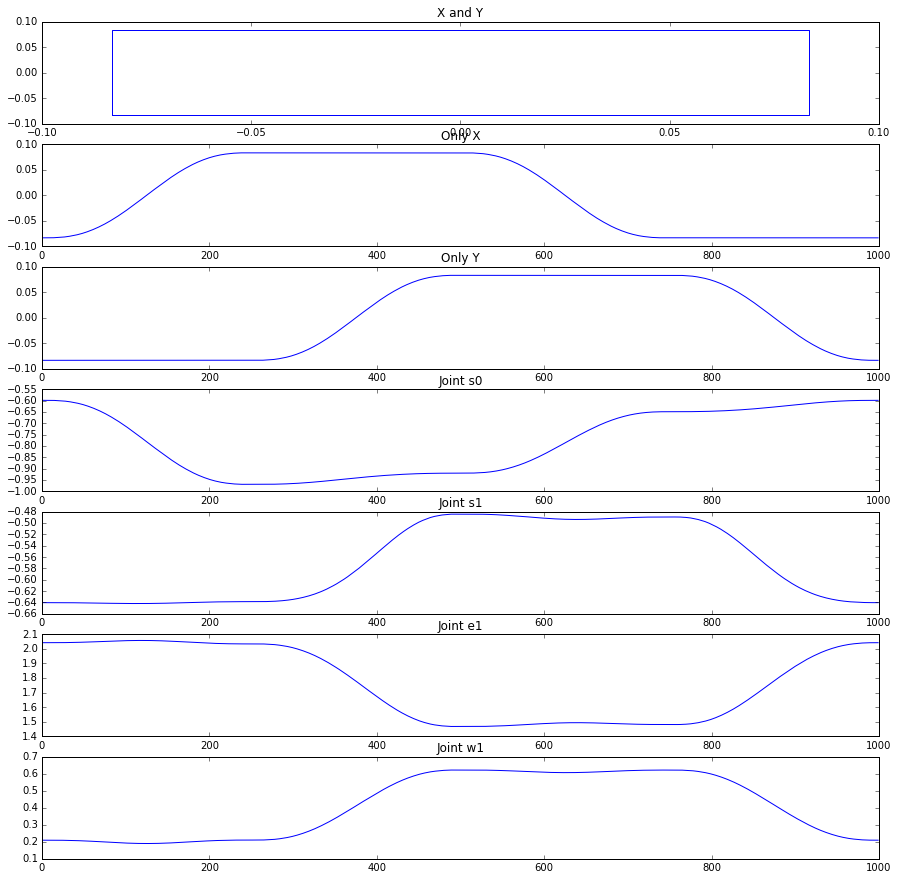

In [18]:
fig=plt.figure(figsize =(15,15));

plt.subplot(7,1,1)
plt.plot(XY_movement[:,0],XY_movement[:,1])
plt.title("X and Y")

plt.subplot(7,1,2)
plt.plot(XY_movement[:,0])
plt.xlim(0,len(XY_movement))
plt.title("Only X")

plt.subplot(7,1,3)
plt.plot(XY_movement[:,1])
plt.xlim(0,len(XY_movement))
plt.title("Only Y")

plt.subplot(7,1,4)
plt.plot(joint_positions[:,0])
plt.xlim(0,len(joint_positions))
plt.title("Joint s0")

plt.subplot(7,1,5)
plt.plot(joint_positions[:,1])
plt.xlim(0,len(joint_positions))
plt.title("Joint s1")

plt.subplot(7,1,6)
plt.plot(joint_positions[:,2])
plt.xlim(0,len(joint_positions))
plt.title("Joint e1")

plt.subplot(7,1,7)
plt.plot(joint_positions[:,3])
plt.xlim(0,len(joint_positions))
plt.title("Joint w1")

plt.show()

In [24]:
#
# Only here the points are saved to a file
#

if save2file:
    numpy.save(base_dir+"/"+sim_set+"/XY_movement_"+sim_set+".npy",joint_positions)